In [1]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime
from dateutil import tz

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy import crs as ccrs
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter

from Map import Map

In [23]:
LOCATION = 'florida'
MODEL = 'gfs'
VARIABLE = 'dpt2m'
RUN_TIME = '06z'
RUN_DATE = '20221113'
VALID_TIME = '2022-11-15T0000'

## Single Variable, No Level

In [24]:
%%capture

model_endpoints = {
    'hrrr': f'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr{RUN_DATE}/hrrr_sfc.t{RUN_TIME}',
    'arw': f'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw{RUN_DATE}/hiresw_conusarw_{RUN_TIME}',
    'nbm': f'https://nomads.ncep.noaa.gov/dods/blend/blend{RUN_DATE}/blend_1hr_{RUN_TIME}',
    'rap': f'https://nomads.ncep.noaa.gov/dods/rap/rap{RUN_DATE}/rap_{RUN_TIME}',
    'gfs': f'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs{RUN_DATE}/gfs_0p25_{RUN_TIME}'
}.get(MODEL, 'gfs')

# Define area to plot
BOTTOM_LAT = 23
TOP_LAT = 40
LEFT_LON = -100
RIGHT_LON = -67

ds = xr.open_dataset(model_endpoints, decode_times=True)

# Take lat and lon slices
LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)

if MODEL == 'gfs':
    LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)
else:
    LON_SLICE = slice(LEFT_LON, RIGHT_LON)
    
# Extract all lats, lons, and meteorological datasets to plot
lats = ds.lat.sel(lat=LAT_SLICE).values

if MODEL == 'gfs':
    lons = ds.lon.sel(lon=LON_SLICE).values
else:
    lons = 360 + ds.lon.sel(lon=LON_SLICE).values


var = ds[VARIABLE].metpy.sel(lat=LAT_SLICE, lon=LON_SLICE, 
                                  time=VALID_TIME).squeeze().metpy.unit_array * units('K')
var = var.to('degF')

def convert_datetime_from_nomads_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

LOCAL_TIME = convert_datetime_from_nomads_to_local(VALID_TIME)

## Setup Basemap and Plot Data

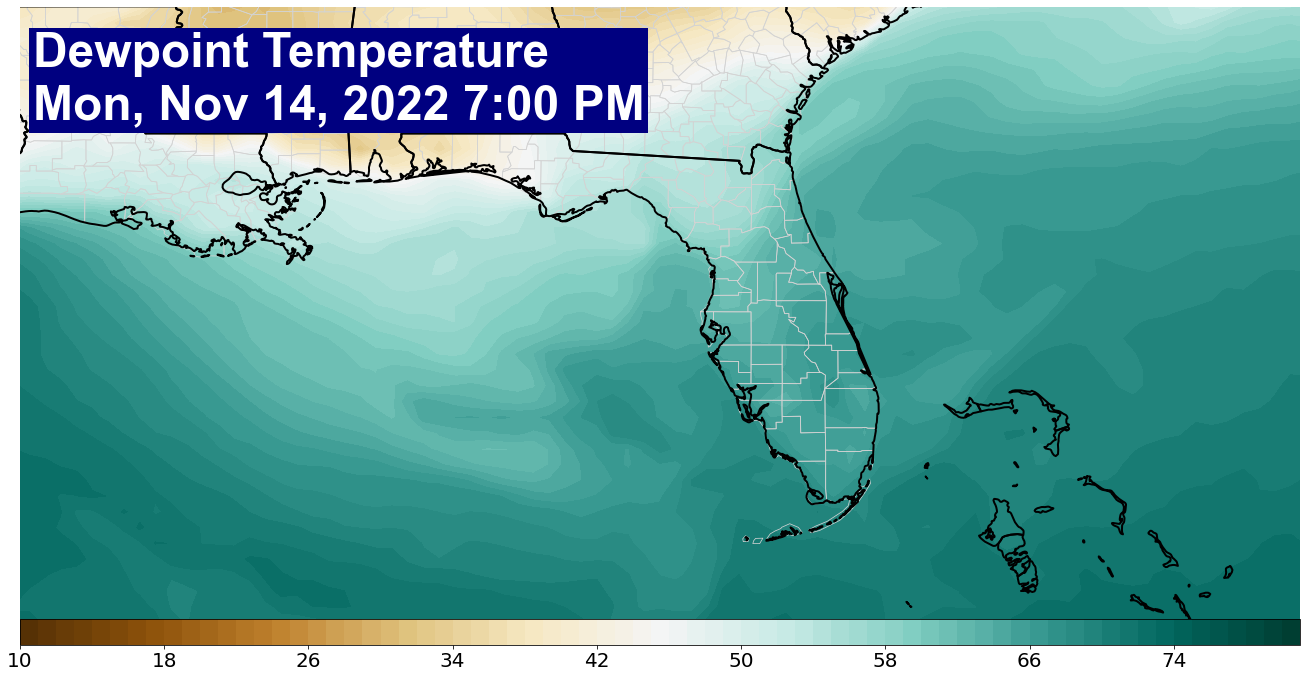

In [25]:
new_map = Map(LOCATION)
new_map.add_counties()
new_map.add_title(f'Dewpoint Temperature\n{LOCAL_TIME}')

fig, ax = new_map.make_map()

# Plot isotachs
var_range = np.arange(10, 82, 1)
contour_fill = ax.contourf(lons, lats, var, var_range,
                      cmap=plt.cm.BrBG, transform=ccrs.PlateCarree())

cbar = fig.colorbar(contour_fill, orientation='horizontal', pad=0, aspect=50)
cbar.ax.tick_params(labelsize=20)

# Save figure
graphics_dir = '../..' / Path('.') / 'graphics' / 'models'
fig.savefig(f'{graphics_dir}/dewpoint_{VALID_TIME}.png', dpi=72)